In [1]:
from data_preprocess.image_matching_dataset import ImageMatchingDataset
import torchvision.transforms as transforms
import torch

# from feature_descriptors.sift_descriptor import get_keypoint_and_descriptor
# from feature_matching.flann_matcher import flann_matcher
# from load_h5py_files import load_sift_output, load_flann_output, load_flann_from_images_name
from clustering.cluster_images import build_graph, graph_clustering
from batch_descriptor import batch_feature_descriptor
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import os
import h5py
import numpy as np
import cv2 as cv

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from torchvision.transforms.functional import pad

class PadToSize():
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        pad_h = max(0, self.size - h)
        pad_w = max(0, self.size - w)
        padding = [pad_w//2, pad_h//2, pad_w - pad_w//2, pad_h - pad_h//2]
        return pad(img, padding, fill=self.fill)

        
'''Original dataset, no resizing performed, does not work with dataloader since it requires all images of same dimensions'''
train_dataset = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   transforms.ToTensor()
                               ]))

'''train_dataset_resize = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   transforms.Resize((1024, 1024)),
                                   transforms.Pad((0, 0, 1024, 1024), fill=0),
                                   transforms.ToTensor()
                               ]))'''


'''Dataset with resizing and padding if needed, to be used with dataloader to work in batches'''
train_dataset_eq_size = ImageMatchingDataset(labels_path='data/train_labels.csv', root_dir='data/train',
                               transform=transforms.Compose([
                                   PadToSize(1024, fill=0),
                                   transforms.Resize((1024, 1024), antialias=True),
                                   transforms.ToTensor()
                               ]))

In [7]:
train_dataset_eq_size[0]

{'image': tensor([[[0.6902, 0.6863, 0.6902,  ..., 0.2980, 0.2941, 0.2941],
          [0.6863, 0.6824, 0.6784,  ..., 0.3020, 0.2941, 0.2941],
          [0.7333, 0.7294, 0.7294,  ..., 0.3294, 0.3294, 0.3373],
          ...,
          [0.3647, 0.3725, 0.3686,  ..., 0.5137, 0.4824, 0.5412],
          [0.3451, 0.3569, 0.3608,  ..., 0.5137, 0.5059, 0.4784],
          [0.3255, 0.3451, 0.3608,  ..., 0.5333, 0.5176, 0.4078]],
 
         [[0.7059, 0.7020, 0.7059,  ..., 0.4392, 0.4353, 0.4353],
          [0.6980, 0.6902, 0.6902,  ..., 0.4431, 0.4353, 0.4353],
          [0.7412, 0.7373, 0.7373,  ..., 0.4706, 0.4706, 0.4784],
          ...,
          [0.5020, 0.5098, 0.5059,  ..., 0.5059, 0.4745, 0.5333],
          [0.4824, 0.4941, 0.4980,  ..., 0.5059, 0.4980, 0.4706],
          [0.4627, 0.4824, 0.4980,  ..., 0.5255, 0.5098, 0.4000]],
 
         [[0.7020, 0.6980, 0.7020,  ..., 0.1569, 0.1529, 0.1529],
          [0.6941, 0.6863, 0.6863,  ..., 0.1608, 0.1529, 0.1529],
          [0.7373, 0.7333, 0.73

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

DEVICE = torch.device(0 if torch.cuda.is_available() else 'cpu')
train_loader = DataLoader(train_dataset_eq_size, batch_size=1, shuffle=True, num_workers=10, pin_memory=True)

In [4]:
batch_feature_descriptor(train_loader, DEVICE, "sift", "evaluation/sift_descriptors_outputs_n/")

In [ ]:
import h5py

def print_h5_structure(name, obj):
    print(name)

with h5py.File("evaluation/sift_descriptors_outputs_n/0_1024_sift.h5", "r") as f:
    f.visititems(print_h5_structure)
    print(f["descriptors"][:])
    print(f["keypoints"][:])
    print(f["scales"][:])
    print(f["oris"][:])
    print(f["image_name"].asstr()[:])
    print(f["dataset_name"].asstr()[:])
    print(f["scene_name"].asstr()[:])
    print(f["image"][:])

In [5]:
# pad keypoints and descriptor, save all of the data in one file

# read data from saved files
sift_dir = "evaluation/sift_descriptors_outputs_n/"

sift_kps = []
sift_desc = []
sift_kps_scores = []
sift_images_name = []
sift_images_path = []
sift_datasets_name = []
sift_scenes_name = []
sift_images = []
sift_scales = []
sift_oris = []
for file in os.listdir(sift_dir):
    if file.endswith(".h5"):
        with h5py.File(sift_dir + file, "r") as f:
            sift_kps.append(torch.from_numpy(f["keypoints"][:]).squeeze(0))
            sift_desc.append(torch.from_numpy(f["descriptors"][:]).squeeze(0))
            sift_oris.append(torch.from_numpy(f["oris"][:]).squeeze(0))
            sift_scales.append(torch.from_numpy(f["scales"][:]).squeeze(0))
            sift_kps_scores.append(torch.from_numpy(f["keypoint_scores"][:]).squeeze(0))
            sift_images_name += list(f["image_name"].asstr())
            sift_images_path += list(f["image_path"].asstr())
            sift_datasets_name += list(f["dataset_name"].asstr())
            sift_scenes_name += list(f["scene_name"].asstr())
            image_data = f["image"][:]  # load as NumPy array

            # Ensure it's 3D (C,H,W) or 2D (H,W)
            if image_data.ndim == 4 and image_data.shape[0] == 1:  
                image_data = image_data[0]  # remove batch dimension
            
            # Convert to PyTorch if needed
            image_tensor = torch.from_numpy(image_data)
            sift_images.append(image_tensor)
            #sift_images.append(f["image"][:].squeeze(0))

In [35]:
print(sift_scales[30].shape)
print(sift_kps[30].shape)

torch.Size([1614])
torch.Size([1614, 2])


In [21]:
sift_kps

[tensor([[633.7606, 552.0565],
         [633.7313, 706.1934],
         [633.4692, 393.4461],
         ...,
         [387.3881, 431.4466],
         [362.8781, 833.2775],
         [346.4166, 397.6566]]),
 tensor([[ 335.3021,  562.1010],
         [1021.1985,  305.2823],
         [1021.1008,  314.9099],
         ...,
         [ 967.3002,  487.2181],
         [ 113.3158,  622.9034],
         [ 497.5984,  743.1748]]),
 tensor([[706.6040, 599.5009],
         [984.7326, 840.2341],
         [156.9524, 842.3416],
         ...,
         [748.7910, 773.2341],
         [762.7715, 362.6022],
         [305.2327, 516.2113]]),
 tensor([[668.8878, 132.2273],
         [744.3217, 341.6897],
         [730.7963, 210.1095],
         ...,
         [392.7366, 715.6465],
         [238.4965, 735.5077],
         [796.9564, 720.5215]]),
 tensor([[283.9579, 863.5632],
         [  2.3980, 668.0386],
         [797.5715, 519.7805],
         ...,
         [197.0100, 515.6307],
         [316.7077, 847.3138],
         [2

In [25]:
lengths = [k.size(0) for k in sift_kps]

sift_kps_pad = pad_sequence(sift_kps, batch_first=True, padding_value=0.0)
sift_desc_pad = pad_sequence(sift_desc, batch_first=True, padding_value=0.0)
sift_scales_pad = pad_sequence(sift_scales, batch_first=True, padding_value=0.0)
sift_oris_pad = pad_sequence(sift_oris, batch_first=True, padding_value=0.0)
sift_kps_scores_pad = pad_sequence([s.view(-1).to(dtype=torch.float32) for s in sift_kps_scores],
                              batch_first=True, padding_value=float('-inf'))

B, Nmax = sift_kps_pad.size(0), sift_kps_pad.size(1)
device = sift_kps_pad.device
valid_mask = (torch.arange(Nmax, device=device).unsqueeze(0).expand(B, Nmax) <
      torch.tensor(lengths, device=device).unsqueeze(1))

In [26]:
print(sift_kps_pad.shape)
print(sift_desc_pad.shape)
print(sift_kps_scores_pad.shape)
print(valid_mask.shape)
print(sift_scales_pad.shape)
print(sift_oris_pad.shape)

torch.Size([1945, 1928, 2])
torch.Size([1945, 1928, 128])
torch.Size([1945, 1928])
torch.Size([1945, 1928])
torch.Size([1945, 1928])
torch.Size([1945, 1928])


In [24]:
sift_kps_pad

tensor([[[ 633.7606,  552.0565],
         [ 633.7313,  706.1934],
         [ 633.4692,  393.4461],
         ...,
         [   0.0000,    0.0000],
         [   0.0000,    0.0000],
         [   0.0000,    0.0000]],

        [[ 335.3021,  562.1010],
         [1021.1985,  305.2823],
         [1021.1008,  314.9099],
         ...,
         [   0.0000,    0.0000],
         [   0.0000,    0.0000],
         [   0.0000,    0.0000]],

        [[ 706.6040,  599.5009],
         [ 984.7326,  840.2341],
         [ 156.9524,  842.3416],
         ...,
         [   0.0000,    0.0000],
         [   0.0000,    0.0000],
         [   0.0000,    0.0000]],

        ...,

        [[1021.2213,  475.2462],
         [ 185.9965,  557.5434],
         [1020.9020,  501.2188],
         ...,
         [   0.0000,    0.0000],
         [   0.0000,    0.0000],
         [   0.0000,    0.0000]],

        [[ 618.8981,  542.9086],
         [ 617.8083,  330.8954],
         [ 275.3189,  630.4749],
         ...,
         [   0.00

In [27]:
# save new data in one file

filename = os.path.join(sift_dir + "merged.h5")

with h5py.File(filename, "w") as f:
    dt = h5py.string_dtype(encoding="utf-8")
    f.create_dataset('keypoints', data=sift_kps_pad.cpu().detach().numpy())
    f.create_dataset('keypoint_scores', data=sift_kps_scores_pad.cpu().detach().numpy())
    f.create_dataset('descriptors', data=sift_desc_pad.cpu().detach().numpy())
    f.create_dataset('keypoints_mask', data=valid_mask.cpu().detach().numpy())
    f.create_dataset('image_name', data=sift_images_name, dtype=dt)
    f.create_dataset('oris', data=sift_oris_pad.cpu().detach().numpy())
    f.create_dataset('scales', data=sift_scales_pad.cpu().detach().numpy())
    f.create_dataset('dataset_name', data=sift_datasets_name, dtype=dt)
    f.create_dataset('scene_name', data=sift_scenes_name, dtype=dt)
    f.create_dataset('image_path', data=sift_images_path, dtype=dt)
    f.create_dataset('image', data=np.array(sift_images))

dataset_name: (1945,) rows
descriptors: (1945, 1928, 128) rows
image: (1945, 3, 1024, 1024) rows
image_name: (1945,) rows
image_path: (1945,) rows
keypoint_scores: (1945, 1928) rows
keypoints: (1945, 1928, 2) rows
keypoints_mask: (1945, 1928) rows
oris: (1945, 1928) rows
scales: (1945, 1928) rows
scene_name: (1945,) rows
[[[ 675.4667    39.95281]
  [ 674.5269   214.78845]
  [ 739.198    710.36053]
  ...
  [   0.         0.     ]
  [   0.         0.     ]
  [   0.         0.     ]]

 [[ 196.98854  414.83234]
  [ 724.6969   335.69333]
  [ 770.06     293.17004]
  ...
  [   0.         0.     ]
  [   0.         0.     ]
  [   0.         0.     ]]

 [[ 173.5297   745.9206 ]
  [ 604.04047  774.0838 ]
  [ 605.56635  640.81396]
  ...
  [   0.         0.     ]
  [   0.         0.     ]
  [   0.         0.     ]]

 ...

 [[1021.03534  912.1247 ]
  [ 499.58807  808.29034]
  [ 243.93707  944.4092 ]
  ...
  [   0.         0.     ]
  [   0.         0.     ]
  [   0.         0.     ]]

 [[ 515.5258   

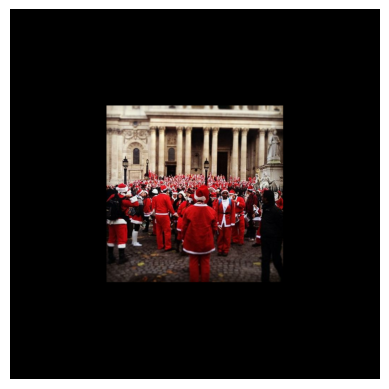

In [28]:
import matplotlib.pyplot as plt

with h5py.File("evaluation/sift_descriptors_outputs_n/merged.h5", "r") as f:
    for key in f.keys():
        num_rows = f[key].shape
        print(f"{key}: {num_rows} rows")

    kps_merged = np.array(f["descriptors"][:])
    print(f["keypoints"][:])
    plt.imshow(np.transpose(f["image"][4][:].squeeze(), (1, 2, 0)), cmap="gray")
    plt.axis("off")
    plt.show()
    # print(f["descriptors"][:])
    # print(f["image_name"].asstr()[:])
    # print(f["image"][:][0])

In [42]:
kps_merged

array([[[ 585.6262 ,  571.4224 ],
        [ 583.6034 ,  665.56195],
        [ 583.29895,  501.2842 ],
        ...,
        [   0.     ,    0.     ],
        [   0.     ,    0.     ],
        [   0.     ,    0.     ]],

       [[ 650.3643 ,  486.78177],
        [ 190.64583,  789.53345],
        [ 464.73422,  362.7954 ],
        ...,
        [   0.     ,    0.     ],
        [   0.     ,    0.     ],
        [   0.     ,    0.     ]],

       [[ 587.8468 ,  380.87146],
        [ 111.53747,  771.28644],
        [ 112.5884 ,  775.09174],
        ...,
        [   0.     ,    0.     ],
        [   0.     ,    0.     ],
        [   0.     ,    0.     ]],

       ...,

       [[1021.1425 ,  215.01436],
        [ 679.2336 ,  829.471  ],
        [ 679.66003,  804.4237 ],
        ...,
        [   0.     ,    0.     ],
        [   0.     ,    0.     ],
        [   0.     ,    0.     ]],

       [[ 454.68423,  252.85074],
        [ 576.4648 ,  431.64352],
        [ 575.9941 ,  289.2771 ],
        .

In [46]:
kps_merged[0]

array([[585.6262 , 571.4224 ],
       [583.6034 , 665.56195],
       [583.29895, 501.2842 ],
       ...,
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ]], shape=(1928, 2), dtype=float32)

In [45]:
# example: way to remove the padding if later using flann

kps_without_pad = [kps[(kps[:, 0] != 0) & (kps[:, 1] != 0)] for kps in kps_merged]
kps_without_pad

[array([[585.6262 , 571.4224 ],
        [583.6034 , 665.56195],
        [583.29895, 501.2842 ],
        ...,
        [345.56717, 623.4795 ],
        [666.94116, 831.7335 ],
        [465.9309 , 668.9876 ]], shape=(1758, 2), dtype=float32),
 array([[650.3643 , 486.78177],
        [190.64583, 789.53345],
        [464.73422, 362.7954 ],
        ...,
        [919.4657 , 719.64954],
        [794.6906 , 841.9982 ],
        [367.88333, 422.83627]], shape=(1723, 2), dtype=float32),
 array([[587.8468 , 380.87146],
        [111.53747, 771.28644],
        [112.5884 , 775.09174],
        ...,
        [444.81104, 196.17389],
        [265.05792, 646.9467 ],
        [413.13275, 770.1012 ]], shape=(1660, 2), dtype=float32),
 array([[376.5433  ,  43.044514],
        [653.48224 , 467.9754  ],
        [653.0467  , 692.8986  ],
        ...,
        [107.7535  , 929.8962  ],
        [778.8806  , 250.73228 ],
        [473.71875 , 874.32245 ]], shape=(1715, 2), dtype=float32),
 array([[495.19537 , 543.933   ]

In [44]:
kps_without_pad[0]

array([[585.6262 , 571.4224 ],
       [583.6034 , 665.56195],
       [583.29895, 501.2842 ],
       ...,
       [345.56717, 623.4795 ],
       [666.94116, 831.7335 ],
       [465.9309 , 668.9876 ]], shape=(1758, 2), dtype=float32)

## disk

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

DEVICE = torch.device(0 if torch.cuda.is_available() else 'cpu')
train_loader = DataLoader(train_dataset_eq_size, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

batch_feature_descriptor(train_loader, DEVICE, "disk", "evaluation/disk_descriptors_outputs/")

In [5]:
import h5py
import numpy as np
from pathlib import Path
import glob

root = Path("evaluation/disk_descriptors_outputs")
file_gen = root.glob("[0-9]*.h5")

if not file_gen:
    raise ValueError("No .h5 files found in the folder.")

first_file = next(file_gen)
with h5py.File(first_file, "r") as f:
    keys = list(f.keys())


with h5py.File(root / "merged.h5", "w") as fout:

    for key in keys:
        # Determine the dtype and initial shape from first file
        with h5py.File(first_file, "r") as f:
            data = f[key][...]
        fout.create_dataset(key, data=data, maxshape=(None,) + data.shape[1:])

    #iterate over the remaining files
    for filepath in file_gen:  
        with h5py.File(filepath, "r") as f:
            for key in keys:
                old_data = fout[key]
                new_data = f[key][...]
                old_len = old_data.shape[0]
                new_len = new_data.shape[0]
                old_data.resize(old_len + new_len, axis=0)
                old_data[old_len:] = new_data


In [6]:
def print_h5_structure(name, obj):
    print(name)

with h5py.File("evaluation/disk_descriptors_outputs/merged.h5", "r") as f:
    for key in f.keys():
        num_rows = f[key]
        print(f"{key}: {num_rows} rows")

dataset_name: <HDF5 dataset "dataset_name": shape (1945,), type "|O"> rows
descriptors: <HDF5 dataset "descriptors": shape (1945, 2048, 128), type "<f4"> rows
image: <HDF5 dataset "image": shape (1945, 3, 1024, 1024), type "<f4"> rows
image_name: <HDF5 dataset "image_name": shape (1945,), type "|O"> rows
image_path: <HDF5 dataset "image_path": shape (1945,), type "|O"> rows
keypoint_scores: <HDF5 dataset "keypoint_scores": shape (1945, 2048), type "<f4"> rows
keypoints: <HDF5 dataset "keypoints": shape (1945, 2048, 2), type "<f4"> rows
keypoints_mask: <HDF5 dataset "keypoints_mask": shape (1945, 2048), type "<f4"> rows
scene_name: <HDF5 dataset "scene_name": shape (1945,), type "|O"> rows


In [6]:
with h5py.File("evaluation/disk_descriptors_outputs/0_1024_disk.h5", "r") as f:
    print(f["image_name"].asstr()[:])
    # print(f["image"][:])
    print(f["keypoints"][:].shape)

['brandenburg_gate_93110830_1932760362.png' 'peach_0150.png'
 'piazza_san_marco_59702055_3587019674.png'
 'brandenburg_gate_54744886_13665893353.png' 'lizard_00074.png'
 'pond_00644.png' 'church_00093.png' 'sacre_coeur_47788810_3531619701.png']
(8, 2048, 2)
